In [489]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import keras
import cv2

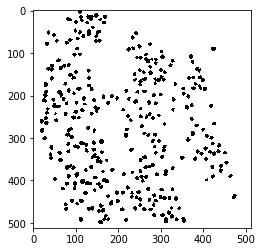

255 1


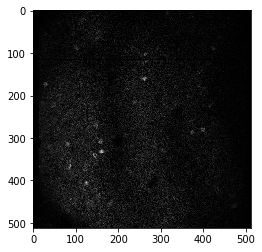

224 0


In [490]:
import cv2
frame_no = 499
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.label.tif') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())
cap = cv2.VideoCapture('Databinary/substack500_7fps_00.avi') #video_name is the video being called
cap.set(1,frame_no); # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
plt.imshow(frame)
plt.show()
print(frame.max(), frame.min())

The input images thus need to be normalised because values are not within the range of 0 and 1. This will hopefully help the network to optimise better

## STATEFUL batch_shape = [1, frag_len, x, y, 1]
    1 sample at a time
    update made after no_fragments batches
    y = [1, 1, x, y, 1]

DEFINE DATA FEEDER

There are two ways to sample the data as illustrated below. Check it out. The only difference is how indexes are defined for data range of each fragment and then the no of resulting fragments.

In [491]:
class Batch_size_1_Generator(object):

    def __init__(self, frag_len, steps = 1):
        self.frag_len = frag_len
        #print(frag_len)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        self.current_count = 0
        self.data = None
        # dimensions expected by the network
        self.dims = (400,256)
        self.steps = steps
    
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def _resizeNnormalize(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        img = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        nomalized = img/255
        return nomalized
    
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
           
            if self.current_count == 0:
                self.current_idx = np.random.randint(10)
            video = cv2.VideoCapture('Databinary/substack500_7fps_0' + str(self.current_idx) + '.avi')

            data_len = 500
            # find out number of fragments for data
            no_frags = int((data_len-frag_len + 1)/steps)
            #no_frags = int(data_len-frag_len + 1)
            
            #print("No frags inside " + str(no_frags))
            self.current_count += 1
            print('current sample number: ' + str(self.current_idx)+', Fragment ' + str(self.current_count)+ ' of ' + str(no_frags))
            
            if self.current_count == no_frags:
                print(self.current_count)
                self.current_count = 0
            data_range = (self.current_count,self.current_count+ self.frag_len)
            #print(data_range)
            
            x = []

            # data_range is the range of frames to be fetched for each fragment
            indxs = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
            #indxs = np.arange(current_count,current_count+ frag_len, steps)
            #for indexer in range(data_range[0],data_range[1]):
            for indexer in indxs:

                video.set(1,indexer) # Where frame_no is the frame you want
                ret, frame = video.read() # Read the frame
                x.append(self._resizeNnormalize(frame, self.dims))
         
            #print('No frags ' + str(no_frags))
            
             
            labels = cv2.VideoCapture('Databinary/substack500_7fps_0' + str(self.current_idx) + '.label.tif')
            labels.set(1,1)
            ret,lab_frame = labels.read()
            y = []
            for indx in range(int((self.frag_len+1)/self.steps)):
                y.append(self._resizeNnormalize(lab_frame, self.dims))
                
            y = np.expand_dims(y, axis=-1)
            x = np.expand_dims(x, axis=-1)
            y = np.expand_dims(y, axis=0)
            x = np.expand_dims(x, axis=0)
           
            #yield x,y
            yield x,y
            

no of fragments and length of fragments changes with the step size so the real length becomes (frag_len+1)/steps and number of fragments is (data_len-frag_len + 1)/steps

In [459]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int((data_len-frag_len + 1)/steps)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count*steps,current_count*steps+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)]).shape

6
[ 1  3  5  7  9 11]
[ 3  5  7  9 11 13]
[ 5  7  9 11 13 15]
[ 7  9 11 13 15 17]
[ 9 11 13 15 17 19]
[11 13 15 17 19 21]


(6,)

no of fragments does not change with the step size but, the actual length of the fragment is changed by the step size. so the real length becomes (frag_len+1)/steps 

In [460]:
example = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22]
data_len = len(example)
frag_len = 11
steps = 2
no_frags = int(data_len-frag_len + 1)
print(no_frags)

for current_count in range(no_frags):
    #ranger = list(range(current_count,current_count+ frag_len))
    indx = np.arange(current_count,current_count+ frag_len, steps)
    print(np.array(example)[indx.astype(int)])
(np.array(example)[indx.astype(int)])

12
[ 1  3  5  7  9 11]
[ 2  4  6  8 10 12]
[ 3  5  7  9 11 13]
[ 4  6  8 10 12 14]
[ 5  7  9 11 13 15]
[ 6  8 10 12 14 16]
[ 7  9 11 13 15 17]
[ 8 10 12 14 16 18]
[ 9 11 13 15 17 19]
[10 12 14 16 18 20]
[11 13 15 17 19 21]
[12 14 16 18 20 22]


array([12, 14, 16, 18, 20, 22])

Quick check to make sure the data is loaded correctly by the data generator. Also a quick check to make sure the images returned are nomalised (value range between 0 and 1). 

NB. Make sure current sample number of next output block is the same as the label vect that is read by cv2 when drawing otherwise images wont match and you might think it is not working

In [471]:
steps = 2
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
print('True fragment length ' +str(true_frag_len))
gener_obj = Batch_size_1_Generator(frag_len, steps)
gener = gener_obj.generate()
X,y = next(gener)

True fragment length 20
current sample number: 3, Fragment 1 of 230


In [472]:
X.shape, y.shape

((1, 20, 256, 400, 1), (1, 20, 256, 400, 1))

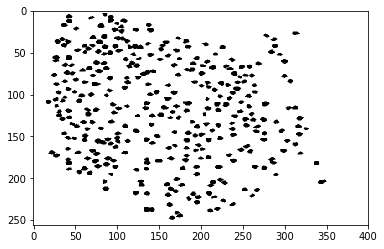

Max value: 255


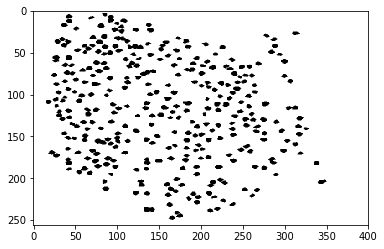

Max value: 1.0


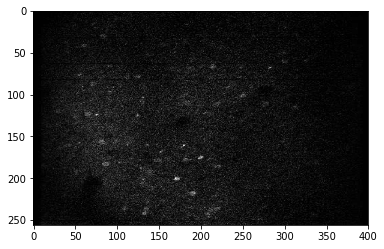

Max value: 0.6274509803921569


In [474]:
vect = cv2.VideoCapture("Databinary/substack500_7fps_03.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()
print('Max value: ' + str(lab_frame.max()))

plt.imshow(y[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(y[0][0].max()))

plt.imshow(X[0][0].reshape(256,400), cmap = 'gray')
plt.show()
print('Max value: ' + str(X[0][0].max()))

DEFINE MODEL

In [492]:
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf

K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

def load_model(true_frag_len):
    input_shape = (None, 256, 400, 1)
    input = Input(batch_shape= [1, true_frag_len, 256,400, 1])

    x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                       input_shape=input_shape,
                       padding='same', 
                       return_sequences=True,
                       stateful = True)(input)
    x = BatchNormalization()(x)
    x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
    output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(x)
    # output = Conv3D(filters=1, kernel_size=(3, 3, 3),
    #                    activation='sigmoid',
    #                    padding='same', data_format='channels_last')(x)


    model_stateful_batch1 = Model(inputs = [input], output=[output])
    model_stateful_batch1.compile(loss='binary_crossentropy', optimizer='adadelta')
    model_stateful_batch1.summary()
    return model_stateful_batch1

TRAIN

In [493]:
data_len = 500
steps = 2
frag_len = 40
true_frag_len = int((frag_len+1)/steps)
no_frags = int((data_len-frag_len + 1)/steps)
#no_frags = int(data_len-frag_len + 1)

print(no_frags)
print(true_frag_len)
model_stateful_batch1 = load_model(true_frag_len)
gener = Batch_size_1_Generator(frag_len, steps)

230
20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (1, 20, 256, 400, 1)      0         
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (1, 20, 256, 400, 14)     7616      
_________________________________________________________________
batch_normalization_16 (Batc (1, 20, 256, 400, 14)     56        
_________________________________________________________________
time_distributed_16 (TimeDis (1, 20, 256, 400, 2)      254       
_________________________________________________________________
output (TimeDistributed)     (1, 20, 256, 400, 1)      3         
Total params: 7,929
Trainable params: 7,901
Non-trainable params: 28
_________________________________________________________________


/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [494]:
no_samples = 5
reps_for_samples = no_samples*no_frags
print("Number of training reps " + str(reps_for_samples))

for reps in range(reps_for_samples):
    if reps%(no_frags) == 0:
        print ('Time to reset states')
        model_stateful_batch1.reset_states()
    train_loss = 0
    X,Y = next(gener.generate())
    train_loss += model_stateful_batch1.train_on_batch(X, Y)
    #print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
    #if reps%no_frags == 0:
    if reps%50 == 0:
        print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
        print(train_loss)
print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
print(train_loss)

Number of training reps 1150
Time to reset states
current sample number: 1, Fragment 1 of 230
# epoch 0   loss  0.6878384947776794
0.6878384947776794
current sample number: 1, Fragment 2 of 230
current sample number: 1, Fragment 3 of 230
current sample number: 1, Fragment 4 of 230
current sample number: 1, Fragment 5 of 230
current sample number: 1, Fragment 6 of 230
current sample number: 1, Fragment 7 of 230
current sample number: 1, Fragment 8 of 230
current sample number: 1, Fragment 9 of 230
current sample number: 1, Fragment 10 of 230
current sample number: 1, Fragment 11 of 230
current sample number: 1, Fragment 12 of 230
current sample number: 1, Fragment 13 of 230
current sample number: 1, Fragment 14 of 230
current sample number: 1, Fragment 15 of 230
current sample number: 1, Fragment 16 of 230
current sample number: 1, Fragment 17 of 230
current sample number: 1, Fragment 18 of 230
current sample number: 1, Fragment 19 of 230
current sample number: 1, Fragment 20 of 230
cur

current sample number: 1, Fragment 176 of 230
current sample number: 1, Fragment 177 of 230
current sample number: 1, Fragment 178 of 230
current sample number: 1, Fragment 179 of 230
current sample number: 1, Fragment 180 of 230
current sample number: 1, Fragment 181 of 230
current sample number: 1, Fragment 182 of 230
current sample number: 1, Fragment 183 of 230
current sample number: 1, Fragment 184 of 230
current sample number: 1, Fragment 185 of 230
current sample number: 1, Fragment 186 of 230
current sample number: 1, Fragment 187 of 230
current sample number: 1, Fragment 188 of 230
current sample number: 1, Fragment 189 of 230
current sample number: 1, Fragment 190 of 230
current sample number: 1, Fragment 191 of 230
current sample number: 1, Fragment 192 of 230
current sample number: 1, Fragment 193 of 230
current sample number: 1, Fragment 194 of 230
current sample number: 1, Fragment 195 of 230
current sample number: 1, Fragment 196 of 230
current sample number: 1, Fragment

current sample number: 8, Fragment 123 of 230
current sample number: 8, Fragment 124 of 230
current sample number: 8, Fragment 125 of 230
current sample number: 8, Fragment 126 of 230
current sample number: 8, Fragment 127 of 230
current sample number: 8, Fragment 128 of 230
current sample number: 8, Fragment 129 of 230
current sample number: 8, Fragment 130 of 230
current sample number: 8, Fragment 131 of 230
current sample number: 8, Fragment 132 of 230
current sample number: 8, Fragment 133 of 230
current sample number: 8, Fragment 134 of 230
current sample number: 8, Fragment 135 of 230
current sample number: 8, Fragment 136 of 230
current sample number: 8, Fragment 137 of 230
current sample number: 8, Fragment 138 of 230
current sample number: 8, Fragment 139 of 230
current sample number: 8, Fragment 140 of 230
current sample number: 8, Fragment 141 of 230
current sample number: 8, Fragment 142 of 230
current sample number: 8, Fragment 143 of 230
current sample number: 8, Fragment

current sample number: 0, Fragment 69 of 230
current sample number: 0, Fragment 70 of 230
current sample number: 0, Fragment 71 of 230
current sample number: 0, Fragment 72 of 230
current sample number: 0, Fragment 73 of 230
current sample number: 0, Fragment 74 of 230
current sample number: 0, Fragment 75 of 230
current sample number: 0, Fragment 76 of 230
current sample number: 0, Fragment 77 of 230
current sample number: 0, Fragment 78 of 230
current sample number: 0, Fragment 79 of 230
current sample number: 0, Fragment 80 of 230
current sample number: 0, Fragment 81 of 230
current sample number: 0, Fragment 82 of 230
current sample number: 0, Fragment 83 of 230
current sample number: 0, Fragment 84 of 230
current sample number: 0, Fragment 85 of 230
current sample number: 0, Fragment 86 of 230
current sample number: 0, Fragment 87 of 230
current sample number: 0, Fragment 88 of 230
current sample number: 0, Fragment 89 of 230
current sample number: 0, Fragment 90 of 230
current sa

current sample number: 1, Fragment 13 of 230
current sample number: 1, Fragment 14 of 230
current sample number: 1, Fragment 15 of 230
current sample number: 1, Fragment 16 of 230
current sample number: 1, Fragment 17 of 230
current sample number: 1, Fragment 18 of 230
current sample number: 1, Fragment 19 of 230
current sample number: 1, Fragment 20 of 230
current sample number: 1, Fragment 21 of 230
current sample number: 1, Fragment 22 of 230
current sample number: 1, Fragment 23 of 230
current sample number: 1, Fragment 24 of 230
current sample number: 1, Fragment 25 of 230
current sample number: 1, Fragment 26 of 230
current sample number: 1, Fragment 27 of 230
current sample number: 1, Fragment 28 of 230
current sample number: 1, Fragment 29 of 230
current sample number: 1, Fragment 30 of 230
current sample number: 1, Fragment 31 of 230
current sample number: 1, Fragment 32 of 230
current sample number: 1, Fragment 33 of 230
current sample number: 1, Fragment 34 of 230
current sa

current sample number: 1, Fragment 190 of 230
current sample number: 1, Fragment 191 of 230
current sample number: 1, Fragment 192 of 230
current sample number: 1, Fragment 193 of 230
current sample number: 1, Fragment 194 of 230
current sample number: 1, Fragment 195 of 230
current sample number: 1, Fragment 196 of 230
current sample number: 1, Fragment 197 of 230
current sample number: 1, Fragment 198 of 230
current sample number: 1, Fragment 199 of 230
current sample number: 1, Fragment 200 of 230
current sample number: 1, Fragment 201 of 230
current sample number: 1, Fragment 202 of 230
current sample number: 1, Fragment 203 of 230
current sample number: 1, Fragment 204 of 230
current sample number: 1, Fragment 205 of 230
current sample number: 1, Fragment 206 of 230
current sample number: 1, Fragment 207 of 230
current sample number: 1, Fragment 208 of 230
current sample number: 1, Fragment 209 of 230
current sample number: 1, Fragment 210 of 230
current sample number: 1, Fragment

current sample number: 7, Fragment 135 of 230
current sample number: 7, Fragment 136 of 230
current sample number: 7, Fragment 137 of 230
current sample number: 7, Fragment 138 of 230
current sample number: 7, Fragment 139 of 230
current sample number: 7, Fragment 140 of 230
current sample number: 7, Fragment 141 of 230
current sample number: 7, Fragment 142 of 230
current sample number: 7, Fragment 143 of 230
current sample number: 7, Fragment 144 of 230
current sample number: 7, Fragment 145 of 230
current sample number: 7, Fragment 146 of 230
current sample number: 7, Fragment 147 of 230
current sample number: 7, Fragment 148 of 230
current sample number: 7, Fragment 149 of 230
current sample number: 7, Fragment 150 of 230
current sample number: 7, Fragment 151 of 230
current sample number: 7, Fragment 152 of 230
current sample number: 7, Fragment 153 of 230
current sample number: 7, Fragment 154 of 230
current sample number: 7, Fragment 155 of 230
current sample number: 7, Fragment

PREDICT

In [478]:
# Predict using just a single sample loaded from file
gener_1 = Batch_size_1_Generator(frag_len, steps).generate()

In [479]:

# this just tests out one sample. I think it is necessary to reset states on prediction too
stateful_preds = []
model_stateful_batch1.reset_states()
for fragment in range(no_frags):
    X,Y = next(gener_1)
    stateful_batch_1 = model_stateful_batch1.predict_on_batch(X)
    stateful_preds.append(stateful_batch_1)
model_stateful_batch1.reset_states() 

current sample number: 4, Fragment 1 of 230
current sample number: 4, Fragment 2 of 230
current sample number: 4, Fragment 3 of 230
current sample number: 4, Fragment 4 of 230
current sample number: 4, Fragment 5 of 230
current sample number: 4, Fragment 6 of 230
current sample number: 4, Fragment 7 of 230
current sample number: 4, Fragment 8 of 230
current sample number: 4, Fragment 9 of 230
current sample number: 4, Fragment 10 of 230
current sample number: 4, Fragment 11 of 230
current sample number: 4, Fragment 12 of 230
current sample number: 4, Fragment 13 of 230
current sample number: 4, Fragment 14 of 230
current sample number: 4, Fragment 15 of 230
current sample number: 4, Fragment 16 of 230
current sample number: 4, Fragment 17 of 230
current sample number: 4, Fragment 18 of 230
current sample number: 4, Fragment 19 of 230
current sample number: 4, Fragment 20 of 230
current sample number: 4, Fragment 21 of 230
current sample number: 4, Fragment 22 of 230
current sample numb

current sample number: 4, Fragment 182 of 230
current sample number: 4, Fragment 183 of 230
current sample number: 4, Fragment 184 of 230
current sample number: 4, Fragment 185 of 230
current sample number: 4, Fragment 186 of 230
current sample number: 4, Fragment 187 of 230
current sample number: 4, Fragment 188 of 230
current sample number: 4, Fragment 189 of 230
current sample number: 4, Fragment 190 of 230
current sample number: 4, Fragment 191 of 230
current sample number: 4, Fragment 192 of 230
current sample number: 4, Fragment 193 of 230
current sample number: 4, Fragment 194 of 230
current sample number: 4, Fragment 195 of 230
current sample number: 4, Fragment 196 of 230
current sample number: 4, Fragment 197 of 230
current sample number: 4, Fragment 198 of 230
current sample number: 4, Fragment 199 of 230
current sample number: 4, Fragment 200 of 230
current sample number: 4, Fragment 201 of 230
current sample number: 4, Fragment 202 of 230
current sample number: 4, Fragment

In [496]:
len(stateful_preds), stateful_preds[0].shape

(230, (1, 20, 256, 400, 1))

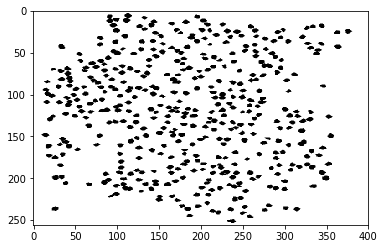

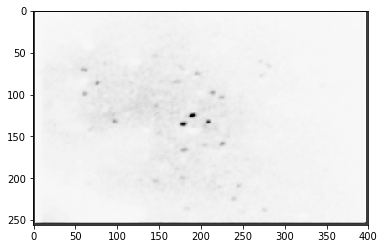

In [487]:
predicted = stateful_preds[200].reshape(20,256,400)

vect = cv2.VideoCapture("Databinary/substack500_7fps_04.label.tif")
vect.set(1,1)
ret,lab_frame = vect.read()
lab_frame = cv2.resize(lab_frame,(400,256))
#truth = lab_frame[0].reshape(256,400)
plt.imshow(lab_frame, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predicted[19], cmap = 'gray')
plt.show()